# Exp6: 基于集成学习的 Amazon 用户评论质量预测

## 一、案例简介

随着电商平台的兴起，以及疫情的持续影响，线上购物在我们的日常生活中扮演着越来越重要的角色。在进行线上商品挑选时，评论往往是我们十分关注的一个方面。然而目前电商网站的评论质量参差不齐，甚至有水军刷好评或者恶意差评的情况出现，严重影响了顾客的购物体验。因此，对于评论质量的预测成为电商平台越来越关注的话题，如果能自动对评论质量进行评估，就能根据预测结果避免展现低质量的评论。本案例中我们将基于集成学习的方法对 Amazon 现实场景中的评论质量进行预测。

## 二、作业说明

本案例中需要大家完成两种集成学习算法的实现（Bagging、AdaBoost.M1），其中基分类器要求使用 SVM 和决策树两种，因此，一共需要对比四组结果（[AUC](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics) 作为评价指标）：

* Bagging + SVM
* Bagging + 决策树
* AdaBoost.M1 + SVM
* AdaBoost.M1 + 决策树

注意集成学习的核心算法需要**手动进行实现**，基分类器可以调库。

### 基本要求
* 根据数据格式设计特征的表示
* 汇报不同组合下得到的 AUC
* 结合不同集成学习算法的特点分析结果之间的差异
* （使用 sklearn 等第三方库的集成学习算法会酌情扣分）

### 扩展要求
* 尝试其他基分类器（如 k-NN、朴素贝叶斯）
* 分析不同特征的影响
* 分析集成学习算法参数的影响

## 三、数据概览

In [1]:
import pandas as pd
train_df = pd.read_csv('./data/train.csv', sep='\t')

In [2]:
train_df

,reviewerID,asin,reviewText,overall,votes_up,votes_all,label
0,7885,3901,"First off, allow me to correct a common mistak...",5.0,6,7,0
1,52087,47978,I am really troubled by this Story and Enterta...,3.0,99,134,0
2,5701,3667,A near-perfect film version of a downright glo...,4.0,14,14,1
3,47191,40892,Keep your expectations low. Really really low...,1.0,4,7,0
4,40957,15367,"""they dont make em like this no more...""well.....",5.0,3,6,0
...,...,...,...,...,...,...,...
57034,58315,29374,"If you like beautifully shot, well acted films...",2.0,12,21,0
57035,23328,45548,This is a great set of films Wayne did Fox and...,5.0,15,18,0
57036,27203,42453,It's what's known as a comedy of manners. It's...,3.0,4,5,0
57037,33992,44891,Ellen can do no wrong as far a creating wonder...,5.0,4,5,0


In [3]:
train_df['reviewerID'].value_counts()

20306     43
18774     43
14204     43
2994      43
57599     43
          ..
19251      2
70308      2
88796      2
117491     2
65056      1
Name: reviewerID, Length: 5758, dtype: int64

In [4]:
train_df['asin'].value_counts()

10       113
13627    110
1907     101
13561     93
13495     87
        ... 
37618      1
9594       1
13665      1
24253      1
19198      1
Name: asin, Length: 22465, dtype: int64

In [5]:
train_df['label'].value_counts()

0    44137
1    12902
Name: label, dtype: int64

In [6]:
train_df['text_length'] = train_df['reviewText'].apply(lambda x:len(x.split(' ')))

In [7]:
train_df

,reviewerID,asin,reviewText,overall,votes_up,votes_all,label,text_length
0,7885,3901,"First off, allow me to correct a common mistak...",5.0,6,7,0,416
1,52087,47978,I am really troubled by this Story and Enterta...,3.0,99,134,0,477
2,5701,3667,A near-perfect film version of a downright glo...,4.0,14,14,1,71
3,47191,40892,Keep your expectations low. Really really low...,1.0,4,7,0,117
4,40957,15367,"""they dont make em like this no more...""well.....",5.0,3,6,0,98
...,...,...,...,...,...,...,...,...
57034,58315,29374,"If you like beautifully shot, well acted films...",2.0,12,21,0,478
57035,23328,45548,This is a great set of films Wayne did Fox and...,5.0,15,18,0,267
57036,27203,42453,It's what's known as a comedy of manners. It's...,3.0,4,5,0,375
57037,33992,44891,Ellen can do no wrong as far a creating wonder...,5.0,4,5,0,70


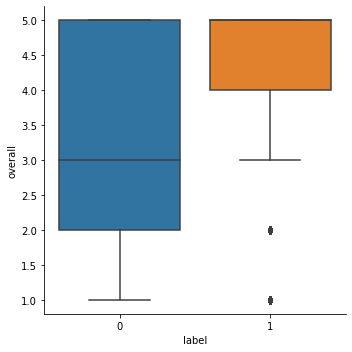

In [8]:
import seaborn as sns
sns.catplot(x='label', y='overall', kind='box', data=train_df)

In [9]:
import numpy as np
train_df[train_df['label'] == 0]['text_length'].mean()

241.19040714140064

In [10]:
train_df[train_df['label'] == 1]['text_length'].mean()

302.8003410323981

In [11]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(train_df['reviewText'], train_df['label'], random_state=2022, )

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer as TFIDF
tfidf = TFIDF(use_idf=1, stop_words='english', ngram_range=(2, 3), min_df=20, max_df=0.5, analyzer='word', max_features=5000)

In [13]:
tfidf.fit(train_x)

TfidfVectorizer(max_df=0.5, max_features=5000, min_df=20, ngram_range=(2, 3),
                stop_words='english', use_idf=1)

In [14]:
tfidf.vocabulary_

{'went film': 4834,
 've seen': 4650,
 'seen films': 4035,
 'sex scenes': 4105,
 'scene involving': 3949,
 'film reason': 1536,
 'gets stars': 1701,
 'marlon brando': 2799,
 'point film': 3520,
 'film good': 1470,
 'complete set': 692,
 'previously released': 3568,
 'complete collection': 689,
 'don believe': 990,
 'star trek': 4233,
 'don feel': 998,
 'did make': 828,
 'video quality': 4682,
 'bit better': 400,
 'better quality': 372,
 'times just': 4527,
 'just went': 2316,
 'picture quality': 3466,
 'quality excellent': 3605,
 'film stock': 1560,
 'dvd player': 1097,
 'surround sound': 4357,
 'sound excellent': 4177,
 'does sound': 953,
 'high notes': 2036,
 'just little': 2271,
 'pretty good': 3557,
 'set dvd': 4087,
 'rock roll': 3868,
 'movie story': 3098,
 'story man': 4294,
 'look bad': 2616,
 'bad bad': 243,
 'bad movie': 254,
 'movie bad': 2900,
 'quot really': 3651,
 'final note': 1621,
 'dvd available': 1054,
 'available dvd': 226,
 'dvd transfer': 1116,
 'wide screen': 484

In [15]:
train_vec = tfidf.transform(train_x)
train_vec.toarray().shape

(42779, 5000)

In [16]:
test_vec = tfidf.transform(test_x)

In [17]:
test_df = pd.read_csv('./data/test.csv', sep='\t')

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
dt = DecisionTreeClassifier(max_depth=10)
dt.fit(np.array(train_vec.todense()), np.array(train_y))
y_pred = dt.predict(np.array(test_vec.todense()))
roc_auc_score(y_pred, test_y)

0.6290368491643882

In [19]:
from sklearn.svm import LinearSVC
svc =LinearSVC()
svc.fit(np.array(train_vec.todense()), np.array(train_y))
y_pred = svc.predict(np.array(test_vec.todense()))
roc_auc_score(y_pred, test_y)

0.6404753407109138

本次数据来源于 Amazon 电商平台，包含超过 50,000 条用户在购买商品后留下的评论，各列的含义如下：

* reviewerID：用户 ID
* asin：商品 ID
* reviewText：英文评论文本
* overall：用户对商品的打分（1-5）
* votes_up：认为评论有用的点赞数（只在训练集出现）
* votes_all：该评论得到的总评价数（只在训练集出现）
* label：评论质量的 label，1 表示高质量，0 表示低质量（只在训练集出现）

评论质量的 label 来自于其他用户对评论的 votes，votes_up/votes_all ≥ 0.9 的作为高质量评论。此外测试集包含一个额外的列Id，标识了每一个测试的样例。

## 四、比赛提交格式

课程页面：https://aistudio.baidu.com/aistudio/education/dashboard

提交文件需要对测试集中每一条评论给出预测为高质量的概率，每行包括一个Id（和测试集对应）以及预测的概率Predicted（0-1的浮点数），用逗号分隔。示例提交格式如下：

```
Id,Predicted
0,0.9
1,0.45
2,0.78
...
```
命名为`result.csv`

**注意除了提交比赛，还需要像之前作业一样在学堂在线提交代码和报告（不包括数据）**

In [20]:
import multiprocessing as mp
import copy
import numpy as np
from sklearn.datasets import dump_svmlight_file
class Bagging():
    '''
    base_models 使用的模型
    n_models 模型数量
    features 使用特征比例
    '''
    def __init__(self , base_models = None, n_models = 10, features = 1):
        if type(base_models) == list:
            self.models = list(base_models)
        else:
            self.models = []
            for i in range(n_models):
                self.models.append(copy.deepcopy(base_models))
        self.n_models = n_models
        self.features = features
    
    
    def fit(self, x, y):
        n, m = np.shape(x)
        if self.features < 1: # 选择特征
            self.feature_select = [np.random.choice(m, int(m*self.features) , replace=False) for i in range(self.n_models)]
        else:
            self.feature_select = [list(range(m))] * self.n_models
        for i in range(self.n_models):
            print('.', end='')
            rnd = np.random.choice(n, n , replace=True) #  有放回随机抽取训练样本
            x_train = x[rnd, :][:, self.feature_select[i]]
            y_train = y[rnd]
            self.models[i].fit(x_train, y_train)   # 训练模型
        
    def predict(self, x):
        result = []
        for i in range(self.n_models):  # 每个模型预测
            result.append(self.models[i].predict(x[:, self.feature_select[i]]))
            
        return np.array([np.argmax(np.bincount(x)) for x in np.array(result).T])  # 返回预测数最多类别
    
    def predict_proba(self, x):
        result = []
        for i in range(self.n_models):
            result.append(self.models[i].predict_proba(x[:, self.feature_select[i]])[:,1])
        return np.array([sum(x) / len(x) for x in np.array(result).T])    # 返回预测为1的概率

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [26]:
bagging_dt = Bagging(base_models=DecisionTreeClassifier(max_depth=3), n_models=100)
bagging_dt.fit(np.array(train_vec.todense()), np.array(train_y))

....................................................................................................

In [27]:
y_pred = bagging_dt.predict(np.array(test_vec.todense()))
roc_auc_score(y_pred, test_y)

0.7635381593714928

In [36]:
from sklearn.svm import LinearSVC
bagging_svc = Bagging(base_models=LinearSVC(C=0.01), n_models=100)
bagging_svc.fit(np.array(train_vec.todense()), np.array(train_y))

....................................................................................................

In [37]:
y_pred = bagging_svc.predict(np.array(test_vec.todense()))
roc_auc_score(y_pred, test_y)

0.7636121246140892

In [51]:
class AdaBoost():
    '''
    base_models 使用的模型
    n_models 模型数量
    features 使用特征比例
    '''
    def __init__(self , base_models = None, n_models = 10, features = 1):
        self.n_models = n_models
        self.base_models = base_models
        self.features = features
    
    
    def fit(self, x, y):
        n, m = np.shape(x)
        model_weights = []
        models = []
        sample_weight = np.ones(n) / n # 初始化样本权重为1/n
        if self.features < 1:
            self.feature_select = [np.random.choice(m, int(m*self.features) , replace=False) for i in range(self.n_models)]
        else:
            self.feature_select = [list(range(m))] * self.n_models
        for i in range(self.n_models):
            print('.', end='')
            train_x = x[:, self.feature_select[i]]
            model = copy.deepcopy(self.base_models)
            model.fit(train_x, y, sample_weight = sample_weight)
            pred = model.predict(train_x)
            error_rate = sum((y != pred) * sample_weight)  # 计算错误率
            if error_rate > 0.5:  
                print("Error: need to use a best model")
            m_w = 1.0 * error_rate / (1 - error_rate)      # 计算模型权重
            models.append(model)
            model_weights.append(m_w)
            sample_weight *= ((y==pred) * m_w + (y!=pred))   #更新样本权重
            sample_weight = sample_weight / sum(sample_weight)   # 样本权重归一化

        self.models = models
        self.model_weights = np.array([np.log2(1 /  w) for w in model_weights])    #计算模型权重
        self.model_weights /= sum(self.model_weights)
        
    
    def predict(self, x):
        result = np.array([self.models[i].predict(x[:, self.feature_select[i]]) for i in range(self.n_models)])
        result = result.T
        pred = []
        for y in result:
            dt = {}
            for k in set(y):
                dt[k] = 0
            for i in range(len(y)):
                dt[y[i]] += self.model_weights[i]   # 计算各类的概率
            pred.append(max(dt, key=dt.get))  # 选择概率最高的作为预测结果
        return np.array(pred)
    
    
    def predict_proba(self, x):
        result = np.array([self.models[i].predict(x[:, self.feature_select[i]]) for i in range(self.n_models)])
        result = result.T
        return (result*self.model_weights).mean(axis=1)   # 各模型概率取平均

In [52]:
adaboost_dt = AdaBoost(base_models=DecisionTreeClassifier(max_depth = 3), n_models=100)
adaboost_dt.fit(np.array(train_vec.todense()), np.array(train_y))
y_pred = adaboost_dt.predict(np.array(test_vec.todense()))
roc_auc_score(y_pred, test_y)

....................................................................................................

0.8052593424068099

In [60]:
adaboost_svc = AdaBoost(base_models=LinearSVC(C=0.01), n_models=100)
adaboost_svc.fit(np.array(train_vec.todense()), np.array(train_y))
y_pred = adaboost_svc.predict(np.array(test_vec.todense()))
roc_auc_score(y_pred, test_y)

....................................................................................................

0.8331189234283753

In [67]:
test_df = pd.read_csv('./data/test.csv', sep='\t')
test_x = tfidf.transform(test_df['reviewText'])

In [68]:
bagging_dt_prob = bagging_dt.predict_proba(test_x)

In [69]:
adaboost_dt_prob = adaboost_dt.predict_proba(test_x)

In [71]:
test_df['Predicted'] = (bagging_dt_prob + adaboost_dt_prob) / 2
test_df.to_csv("result.csv", columns = ['Id', 'Predicted'], index=False)